In [53]:
import os
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pickle
import torch
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint

current_dir = os.path.join(Path().resolve())
# モジュールのあるパスを追加
sys.path.append(str(current_dir) + '/../train')

import model._models as models
import datamodule._datamodules as datamodules
import dataset._datasets as datasets
import route._routes as routes
import mylib.utils as ut
import mylib.config as conf

In [54]:
ROOT_PATH = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
# DF_PATH = os.path.join(ROOT_PATH, "data", "df_test.pickle")
DF_PATH = os.path.join(ROOT_PATH, "data", "df_5s_avg.pickle")
OUTPUT_DIR = os.path.join(ROOT_PATH, "out")
CONFIG_DIR = os.path.join(ROOT_PATH, "config")

In [55]:
log_dir = Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\2024-12-19-11-10-dec_shift4_2ax_route_test")
log_dir = Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\2024-12-18-20-38-dec_2ax_route_test")
# log_dir = Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\2024-11-30-22-24-2p_2ax_noise_route_test")
# log_dir = Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\2024-11-30-22-45-1p_2ax_noise_route_test")


cp_path = os.path.join(log_dir, "cp/last.ckpt")
cp_path = os.path.join(log_dir, "cp/best_loss_fold.ckpt")
config_path = os.path.join(log_dir, "config.yaml")

In [56]:
def plot_route(y, y_hat):
    plt.figure(figsize=(4, 10))
    plt.plot(y[:, 0], y[:, 1], marker="o")
    plt.plot(y_hat[:, 0], y_hat[:, 1], marker="x")
    plt.xlim(0, 3.5)
    plt.ylim(0, 11)
    plt.show()

In [57]:
def plot_route2(x, y, y_hat):
    # 2つのルートをプロット
    fig, ax = plt.subplots(1, 2)
    ax[0].plot(x[0, :, 3], x[0, :, 4], marker="o")
    ax[1].plot(y[0, :, 0], y[0, :, 1], marker="o", label="true")
    ax[1].plot(y_hat[0, :, 0], y_hat[0, :, 1], marker="x", label="pred")
    ax[1].set_xlim(0, 3.5)
    ax[1].set_ylim(0, 11)
    ax[1].legend()
    plt.show()

In [58]:
def get_random_noise(mean, std, shape):
    # ランダムノイズを生成
    random_noise = torch.normal(mean=mean, std=std, size=shape)
    # random_noise = torch.empty(x.shape[0], x.shape[1]).uniform_(-0.5, 0.5)
    return random_noise

In [59]:

ut.fix_seeds(0)
df = pickle.load(open(DF_PATH, "rb"))
config = conf.from_yaml(config_path)
# config = conf.from_yaml(r"C:\Users\hal\Documents\lab\abci\config\config.yaml")

# 各種初期化
model = models.get_model_with_checkpoint(config["model"], cp_path)
route_gen = routes.get_route_generator(config["route"])
dataset = datasets.get_dataset(config["dataset"])
dm = datamodules.get_dm(config["dm"])

dataset.set_route(df, route_gen)
dm.setDataset(dataset)

# train_dataset = datasets.RouteDatasetWithRoute(6400)
# val_dataset = datasets.RouteDatasetWithRoute(1600)
# test_dataset = datasets.RouteDatasetWithRoute(2000)

# train_dataset.set_route(df, route_gen)
# val_dataset.set_route(df, route_gen)
# test_dataset.set_route(df, route_gen)

# dataset = [
#     train_dataset, val_dataset, test_dataset
# ]
df


,x,y,MF,MF_X,MF_Y,MF_Z
0,0,0,47.092824,15.922708,-24.282148,-37.075312
1,1,0,47.006834,15.718135,-25.290383,-36.323777
2,2,0,46.904898,15.512466,-26.195008,-35.626671
3,3,0,46.771071,15.304602,-26.892416,-35.038420
4,4,0,46.589408,15.093445,-27.278996,-34.613452
...,...,...,...,...,...,...
3126,26,100,38.792002,3.686721,-19.262970,-33.319910
3127,27,100,38.170764,2.066179,-19.227704,-32.627471
3128,28,100,37.575150,0.115492,-19.140441,-31.999105
3129,29,100,36.996618,-2.055291,-19.018515,-31.413456


In [ ]:


model.train()


loss_list = []
dist_list = []
for i in range(dm.train_dataset.__len__()):
    batch = dm.train_dataset[i]
    batch = dm.train_dataloader()[i]
    # batch = dm.val_dataset[i]
    # batch = dm.test_dataset[i]

    x, y = batch
    # print(x.shape)
    # print(y.shape)
    x, y = x.view(-1), y.view(-1)

    # print(y)
    shifted_y = torch.zeros_like(y)
    shifted_y[4:] = y[:-4]
    # print(y)

    x = x.unsqueeze(0).cuda()
    y = y.unsqueeze(0).cuda()
    shifted_y = shifted_y.unsqueeze(0).cuda()
    shifted_y = y

    # print(x.shape)
    # print(y.shape)

    # mean = 0.0  # 平均
    # std = 0.381  # 標準偏差
    # x[:, :, 0] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()
    # x[:, :, 1] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()
    # x[:, :, 2] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()

    
    y_hat = model(x, shifted_y)

    # print(y)
    # print(y_hat)


    loss = nn.functional.mse_loss(y_hat, y)
    loss_list.append(loss.item())

    # print(loss.item())

    # print(y_hat.shape)

    x = x.view(20, 4)  # torch.Size([20, 4])
    y = y.view(20, 2)  # torch.Size([20, 2])
    y_hat = y_hat.view(20, 2)  # torch.Size([20, 2])

    # print(y_hat.shape)
    

    x = x.cpu().detach().numpy()
    y_hat = y_hat.cpu().detach().numpy()
    y = y.cpu().detach().numpy()
    # plot_route2(x, y, y_hat)
    
    # print(y)
    # print(y_hat)
    # plot_route(y, y_hat)


    dist_errors = np.linalg.norm(y - y_hat, axis=-1)
    # print(dist_errors)
    dist_mean = np.mean(dist_errors)
    
    dist_list.append(dist_mean)  
    # print(dist_mean)
    

plt.plot(loss_list)
plt.show()

plt.plot(dist_list)
plt.show()

avg = sum(loss_list) / len(loss_list)
print(avg)


TypeError: 'DataLoader' object is not subscriptable

2.053424596786499
2.0411336421966553
1.9627468585968018
2.065664052963257
2.096573829650879
2.0778720378875732
1.9571914672851562
2.3161399364471436
2.171952962875366
2.087819814682007
1.9854084253311157
1.6192665100097656
1.954321265220642
1.7272523641586304
2.021193265914917
1.945349097251892
1.994256615638733
2.1136441230773926
1.9088054895401
1.815642237663269
2.341787815093994
1.4775266647338867
2.5291037559509277
1.7553237676620483
2.328126907348633
2.3311946392059326
1.9943923950195312
1.9225927591323853
1.754961371421814
1.9825481176376343
2.2296292781829834
2.1066243648529053
2.1566696166992188
1.8019722700119019
1.9948691129684448
1.7789331674575806
2.1581363677978516
1.8251718282699585
2.292558193206787
2.072796583175659
1.8428019285202026
1.976907730102539
2.0970966815948486
2.4403817653656006
2.0862841606140137
1.900164008140564
2.152043104171753
1.8880064487457275
1.9726905822753906
2.184358596801758
1.7576887607574463
1.8124897480010986
1.940619707107544
2.41336226463317

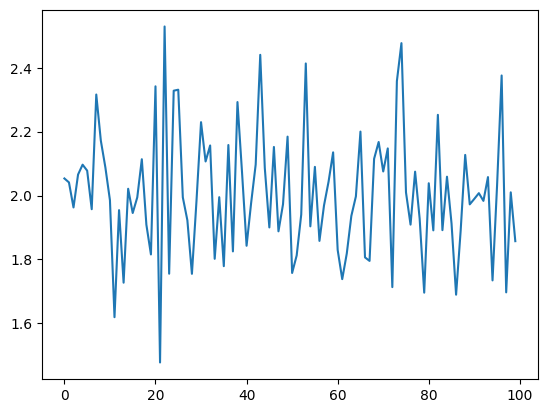

2.00475436091423


In [72]:


model.eval()


loss_list = []
# dist_list = []
for batch in dm.train_dataloader():
    # batch = dm.train_dataset[i]
    # batch = dm.train_dataloader()[i]
    # batch = dm.val_dataset[i]
    # batch = dm.test_dataset[i]

    # x, y = batch

    # x = x.unsqueeze(0).cuda()
    # y = y.unsqueeze(0).cuda()


    x, y = batch
    x, y = x.cuda(), y.cuda()
    x, y = x.view(64, -1), y.view(64, -1)
    shifted_y = torch.zeros_like(y)
    shifted_y[:, 4:] = y[:, :-4]
    # y_hat = self(x, shifted_y)

    # print(x.shape)
    # print(y.shape)

    # mean = 0.0  # 平均
    # std = 0.381  # 標準偏差
    # x[:, :, 0] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()
    # x[:, :, 1] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()
    # x[:, :, 2] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()

    
    y_hat = model(x, shifted_y)

    # print(y)
    # print(y_hat)


    loss = nn.functional.mse_loss(y_hat, y)
    loss_list.append(loss.item())

    print(loss.item())

    # print(y_hat.shape)

    x = x.view(64, 20, 4)  # torch.Size([20, 4])
    y = y.view(64, 20, 2)  # torch.Size([20, 2])
    y_hat = y_hat.view(64, 20, 2)  # torch.Size([20, 2])

    # print(y_hat.shape)
    

    x = x.cpu().detach().numpy()
    y_hat = y_hat.cpu().detach().numpy()
    y = y.cpu().detach().numpy()
    # plot_route2(x, y, y_hat)
    
    # print(y)
    # print(y_hat)
    # plot_route(y, y_hat)


    # dist_errors = np.linalg.norm(y - y_hat, axis=-1)
    # print(dist_errors)
    # dist_mean = np.mean(dist_errors)
    
    # dist_list.append(dist_mean)  
    # print(dist_mean)
    

plt.plot(loss_list)
plt.show()

# plt.plot(dist_list)
# plt.show()

avg = sum(loss_list) / len(loss_list)
print(avg)
